## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
import random
import sklearn.model_selection as skl
import tensorflow as tf
from skimage import io
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten 
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, roc_curve, auc  
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, average_precision_score, f1_score
from sklearn.preprocessing import binarize

# to display model architecture
from keras.utils.vis_utils import model_to_dot
import IPython.display

# fix random_state for reproducibility
random_state = 42

# plotting style
plt.style.use('ggplot')

# fix number of epochs for model training
num_epochs = 40

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3, random_state = random_state)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
89645,00022260_003.png,No Finding,3,22260,54,F,PA,2542,2434,0.143,0.143,NaN,/data/images_010/images/00022260_003.png
47446,00012048_007.png,Infiltration|Mass|Nodule,7,12048,65,M,AP,2500,2048,0.168,0.168,NaN,/data/images_006/images/00012048_007.png
57963,00014352_005.png,No Finding,5,14352,6,M,PA,2992,2033,0.143,0.143,NaN,/data/images_007/images/00014352_005.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda diseases: diseases.split('|')).tolist())))
labels = [label for label in labels if label != 'No Finding']
for label in labels:
    all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)
    print('%s: %d'%(label, int(all_xray_df[label].sum())))

Atelectasis: 11559
Cardiomegaly: 2776
Consolidation: 4667
Edema: 2303
Effusion: 13317
Emphysema: 2516
Fibrosis: 1686
Hernia: 227
Infiltration: 19894
Mass: 5782
Nodule: 6331
Pleural_Thickening: 3385
Pneumonia: 1431
Pneumothorax: 5302


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['pneumonia_class'] = all_xray_df.apply(lambda df: '1' if df['Pneumonia']== 1.0 else '0', axis=1)
all_xray_df.sample(3, random_state = random_state)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
89645,00022260_003.png,No Finding,3,22260,54,F,PA,2542,2434,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
47446,00012048_007.png,Infiltration|Mass|Nodule,7,12048,65,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0
57963,00014352_005.png,No Finding,5,14352,6,M,PA,2992,2033,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Create your training and testing data:

In [5]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    
    train_data, val_data = skl.train_test_split(vargs, 
                                   test_size = 0.2, 
                                   stratify = vargs['pneumonia_class'], 
                                                random_state = random_state)
    
    # extract the index for all pneumonia cases from the train_data and convert to list
    pos_ind = train_data[train_data['pneumonia_class'] == '1'].index.tolist()

    # extract the index for all non-pneumonia cases from the train_data and convert to list
    neg_ind = train_data[train_data['pneumonia_class'] == '0'].index.tolist()

    # randomly sample the neg_ind list to be of the same length as pos_ind
    # use seed for reproducibility
    random.seed(random_state)
    sampled_neg_ind = random.sample(neg_ind, len(pos_ind))

    # extract equal number of pneumonia and non-pneumonia cases
    train_data = train_data.loc[pos_ind + sampled_neg_ind]
    
    val_pos_ind = val_data[val_data['pneumonia_class'] == '1'].index.tolist()
    val_neg_ind = val_data[val_data['pneumonia_class'] == '0'].index.tolist()

    # make the number non-pneumonia data equal 4 times as big as the pneumonia sample.
    # randomly sample the val_neg_ind list to be of the same length as val_pos_ind
    
    sampled_val_neg_ind = random.sample(val_neg_ind, 4*len(val_pos_ind))
    val_data = val_data.loc[val_pos_ind + sampled_val_neg_ind]    
    
    return train_data, val_data

In [6]:
# split the dataset using the create_splits function
train_data, val_data = create_splits(all_xray_df)

In [7]:
# Check the fraction of positive cases in the training dataset
train_data[train_data['pneumonia_class'] == '1']['pneumonia_class'].count()/len(train_data)

0.5

Remarks: training dataset is balanced 1:1

In [8]:
# Check the fraction of positive cases in the validation dataset
val_data[val_data['pneumonia_class'] == '1']['pneumonia_class'].count()/len(val_data)

0.2

Remarks: Validation dataset has 20% prevalence of pneumonial to mirror real clinical scenario

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [9]:
def my_image_augmentation(vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    train_idg = ImageDataGenerator(rescale=1.0/vargs,
                      horizontal_flip = True, 
                      vertical_flip = False, 
                      height_shift_range= 0.1, 
                      width_shift_range=0.1, 
                      rotation_range=20, 
                      shear_range = 0.1,
                      zoom_range=0.1)
    
    val_idg = ImageDataGenerator(rescale=1.0/vargs)
    
    return train_idg, val_idg

In [10]:
train_idg, val_idg = my_image_augmentation(255)

In [11]:
image_size = (224, 224) 

In [12]:
def make_train_gen(vargs):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo
    train_gen = train_idg.flow_from_dataframe(dataframe=vargs, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = image_size, 
                                         batch_size = 32,
                                         seed= random_state
                                         )    # what should inform the batch_size to use?

    return train_gen


def make_val_gen(vargs):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    # Todo
    val_gen = val_idg.flow_from_dataframe(dataframe=vargs, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = image_size, 
                                         batch_size = 32, 
                                         seed = random_state)     
    return val_gen

In [13]:
train_gen = make_train_gen(train_data)
val_gen = make_val_gen(val_data)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [14]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

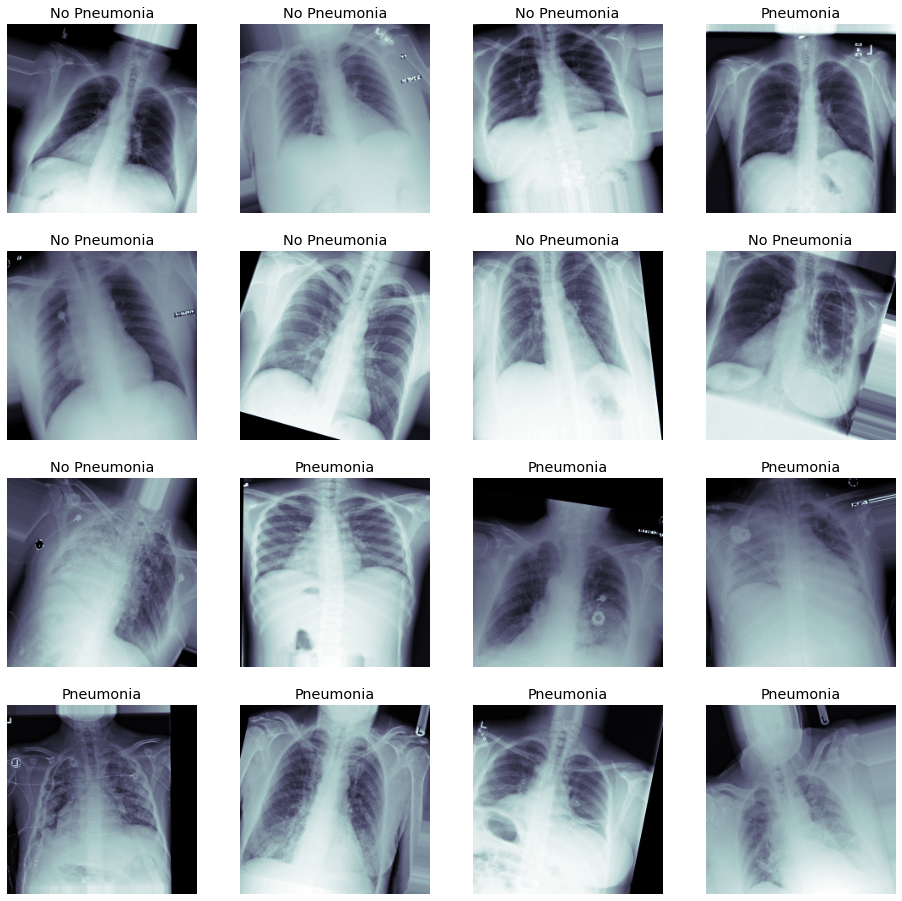

In [15]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [16]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)
    
    return vgg_model


In [17]:
vgg_model = load_pretrained_model()
vgg_model.summary()

553467904/553467096 [==============================] - 7s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________________________________________________________

In [18]:
def build_my_model(vgg_model, layer_num = -1, fc_list = []):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    # freeze all layers up to layer_num
    for layer in vgg_model.layers[0:layer_num]:
        layer.trainable = False
        
    for layer in vgg_model.layers:
        
        print(layer.name, layer.trainable)
    
    # initialize the model
    model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a convolutional layer.
    model.add(Flatten())
    
    if len(fc_list) > 0:
        for i, num in enumerate(fc_list):    
            model.add(Dropout(0.5))
            model.add(Dense(num, activation='relu'))
        
    model.add(Dense(1, activation='sigmoid'))     
    
    # compiling the model
    model.compile(optimizer=Adam(lr=1e-4), 
                     loss='binary_crossentropy', 
                     metrics=['binary_accuracy'])    
    
    return model

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [19]:
## using only the last output layer, no dropout, no FC-layer
## running for 10 epochs to see how if any learning occurs:
my_model = build_my_model(vgg_model)
my_model.fit_generator(train_gen, 
                       validation_data = (valX, valY), 
                       epochs = int(num_epochs/4))

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool True
Epoch 1/10
72/72 [==============================] - 66s 923ms/step - loss: 0.6959 - binary_accuracy: 0.5384 - val_loss: 0.8206 - val_binary_accuracy: 0.3125
Epoch 2/10
72/72 [==============================] - 59s 826ms/step - loss: 0.6728 - binary_accuracy: 0.5895 - val_loss: 0.7494 - val_binary_accuracy: 0.4062
Epoch 3/10
72/72 [==============================] - 59s 817ms/step - loss: 0.6593 - binary_accuracy: 0.6096 - val_loss: 0.7005 - val_binary_accuracy: 0.5625
Epoch 4/10
72/72 [==============================] - 58s 810ms/step - loss: 0.6593 - binary_accuracy: 0.6135 - val_loss: 0.6718 - val_binary_accuracy: 0.5625
Epoch 5/10
72/72 [====

In [20]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

def checkpoint(model):
    weight_path="{}_{}.best.hdf5".format('xray_class', model)

    checkpoint = ModelCheckpoint(weight_path, 
                                  monitor= 'val_loss', 
                                  verbose=1, 
                                  save_best_only=True, 
                                  mode= 'min', 
                                  save_weights_only = True)

    early = EarlyStopping(monitor= 'val_loss', 
                           mode= 'min', 
                           patience=10)

    callbacks_list = [checkpoint, early]
    
    return weight_path, callbacks_list
    

In [21]:
weight_path, callbacks_list = checkpoint(my_model)

### Start training! 

In [22]:
## train your model

# Todo

hist = my_model.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = num_epochs, 
                           callbacks = callbacks_list)

Epoch 1/40
72/72 [==============================] - 59s 813ms/step - loss: 0.6362 - binary_accuracy: 0.6410 - val_loss: 0.6699 - val_binary_accuracy: 0.5625

Epoch 00001: val_loss improved from inf to 0.66989, saving model to xray_class_<keras.engine.sequential.Sequential object at 0x7fdcaa1060d0>.best.hdf5
Epoch 2/40
72/72 [==============================] - 58s 802ms/step - loss: 0.6384 - binary_accuracy: 0.6336 - val_loss: 0.7264 - val_binary_accuracy: 0.4375

Epoch 00002: val_loss did not improve from 0.66989
Epoch 3/40
72/72 [==============================] - 57s 798ms/step - loss: 0.6382 - binary_accuracy: 0.6415 - val_loss: 0.6459 - val_binary_accuracy: 0.6875

Epoch 00003: val_loss improved from 0.66989 to 0.64590, saving model to xray_class_<keras.engine.sequential.Sequential object at 0x7fdcaa1060d0>.best.hdf5
Epoch 4/40
72/72 [==============================] - 59s 818ms/step - loss: 0.6357 - binary_accuracy: 0.6410 - val_loss: 0.7735 - val_binary_accuracy: 0.4375

Epoch 00004

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [23]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

32/32 [==============================] - 0s 11ms/step


### Visualizations and evaluations

In [70]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fig, ax = plt.subplots(1,1, figsize = (7, 7))    
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    ax.plot(fpr, tpr, label = 'AUC = %0.3f'  % (auc(fpr, tpr)))
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate') 
    #ax.set_xlim([0, 1])
    #ax.set_ylim([0, 1])
    ax.legend(loc = 'best')
    return

## what other performance statistics do you want to include here besides AUC? 

def f1_plot(t_y, p_y):
        
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    f1s = [f1_score(t_y, binarize(p_y, ind)) for ind in thresholds]
    fig, ax = plt.subplots(1,1, figsize = (7, 7))
    ax.plot(thresholds, f1s, label = 'F1 Score')
    ax.legend()
    ax.set_xlabel('Threshold')
    ax.set_ylabel('F1 Score')
    ax.set_title('F1_score vs Threshold')

    return

def prec_recall_plot(t_y, p_y):
# Todo
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    fig, ax = plt.subplots(1,1, figsize = (7, 7))
    ax.plot(recall, precision)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve')
    return
    
#Also consider plotting the history of your model training:
def plot_history(history):        
    # Todo
    x_values = np.arange(0, len(history.history["loss"]))
    metrics = ["loss", "val_loss", "binary_accuracy", "val_binary_accuracy"]
    labels = ["train_loss", "val_loss", "train_acc", "val_acc"]
    markers = ['k-', 'r-', 'b-', 'g-']
    plt.figure(figsize=(7,7))
    for ind, metric in enumerate(metrics):
        plt.plot(x_values, history.history[metric], markers[ind] , label=labels[ind])
    plt.title("Training & Validation Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="best")    
    return

# function to calculate the F1 score
def calc_f1(precision,recall):
    return 2*(precision*recall)/(precision+recall)

# function to obtain threshold at maximum f1_score => best threshold

def best_threshold(precision, recall):
    
    """
    This function finds the threshold at maximum f1_score computed 
    from input precision and recall. It prints the threshold and the 
    corresponding precision and recall.   
    
    """   
    f1_score = calc_f1(precision, recall)
    idx_max_f1_score = np.nanargmax(f1_score) # find the index at maximum f1_score
    best_threshold = thresholds[idx_max_f1_score]
    # print corresponding threshold, precision and recall
    print('Threshold that maximized f1_score is: %.2f'%best_threshold)
    print('Corresponding Precision is: %.2f'%precision[idx_max_f1_score])
    print('Recall is: %.2f'%recall[idx_max_f1_score])
    
    return best_threshold

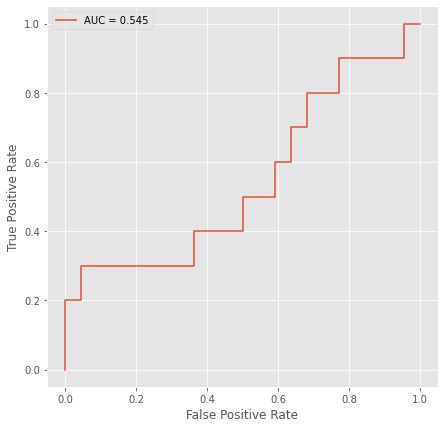

In [25]:
plot_auc(valY, pred_Y)

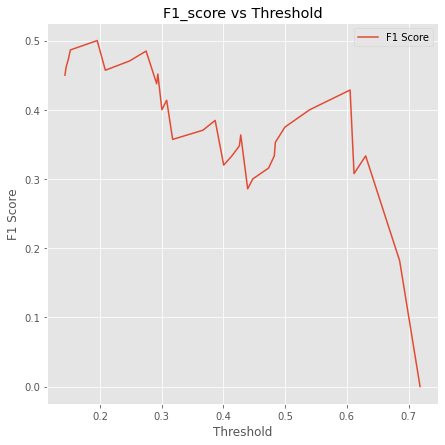

In [26]:
f1_plot(valY, pred_Y)

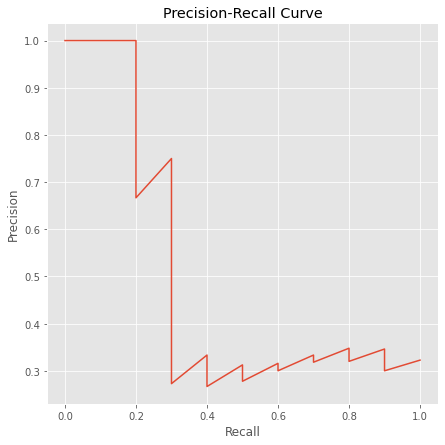

In [27]:
prec_recall_plot(valY, pred_Y)

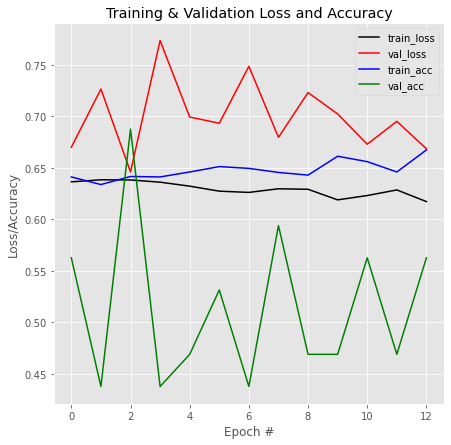

In [28]:
plot_history(hist)

**Comments 

Model is not learning - overfitting. Need to add droupout and full-connected layer(s)

### Trying out different architectures

#### 1. Freezing last layer, adding drop-out, and connecting 1 FC-layers

In [29]:
## using only the last output layer, dropout and 1 FC-layer
## running for 10 epochs to see how if any learning occurs:
my_model1 = build_my_model(vgg_model, layer_num = -1, fc_list = [1024])
my_model1.fit_generator(train_gen, 
                       validation_data = (valX, valY), 
                       epochs = int(num_epochs/4))

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool True
Epoch 1/10
72/72 [==============================] - 59s 825ms/step - loss: 0.7852 - binary_accuracy: 0.5415 - val_loss: 0.6942 - val_binary_accuracy: 0.5312
Epoch 2/10
72/72 [==============================] - 59s 818ms/step - loss: 0.7108 - binary_accuracy: 0.5895 - val_loss: 0.6088 - val_binary_accuracy: 0.6875
Epoch 3/10
72/72 [==============================] - 59s 819ms/step - loss: 0.6920 - binary_accuracy: 0.5913 - val_loss: 0.5900 - val_binary_accuracy: 0.7188
Epoch 4/10
72/72 [==============================] - 60s 829ms/step - loss: 0.6681 - binary_accuracy: 0.6096 - val_loss: 0.7782 - val_binary_accuracy: 0.5000
Epoch 5/10
72/72 [====

In [30]:
weight_path1, callbacks_list1 = checkpoint(my_model1)

In [31]:
hist1 = my_model1.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = num_epochs, 
                           callbacks = callbacks_list1)

Epoch 1/40
72/72 [==============================] - 59s 819ms/step - loss: 0.6437 - binary_accuracy: 0.6266 - val_loss: 0.7956 - val_binary_accuracy: 0.4688

Epoch 00001: val_loss improved from inf to 0.79564, saving model to xray_class_<keras.engine.sequential.Sequential object at 0x7fdca835c810>.best.hdf5
Epoch 2/40
72/72 [==============================] - 58s 806ms/step - loss: 0.6669 - binary_accuracy: 0.6114 - val_loss: 0.6067 - val_binary_accuracy: 0.6250

Epoch 00002: val_loss improved from 0.79564 to 0.60669, saving model to xray_class_<keras.engine.sequential.Sequential object at 0x7fdca835c810>.best.hdf5
Epoch 3/40
72/72 [==============================] - 58s 808ms/step - loss: 0.6497 - binary_accuracy: 0.6188 - val_loss: 0.6581 - val_binary_accuracy: 0.5625

Epoch 00003: val_loss did not improve from 0.60669
Epoch 4/40
72/72 [==============================] - 58s 806ms/step - loss: 0.6493 - binary_accuracy: 0.6131 - val_loss: 0.5918 - val_binary_accuracy: 0.7188

Epoch 00004

In [32]:
my_model1.load_weights(weight_path1)
pred_Y1 = my_model1.predict(valX, batch_size = 32, verbose = True)

32/32 [==============================] - 0s 11ms/step


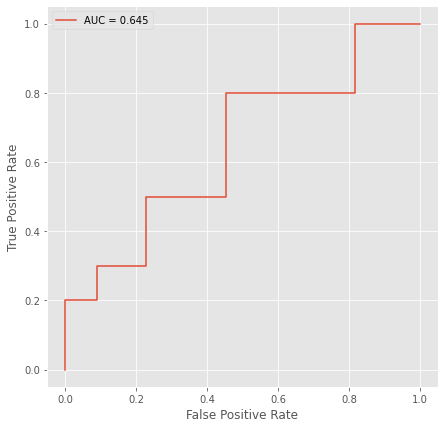

In [33]:
plot_auc(valY, pred_Y1)

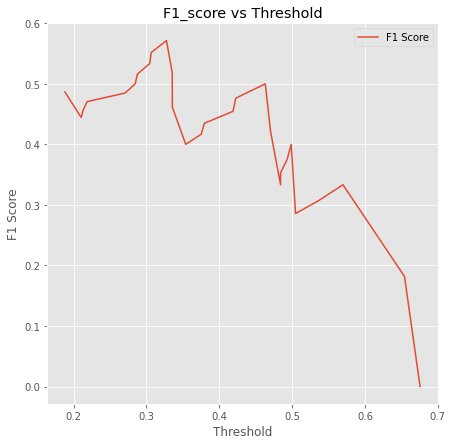

In [34]:
f1_plot(valY, pred_Y1)

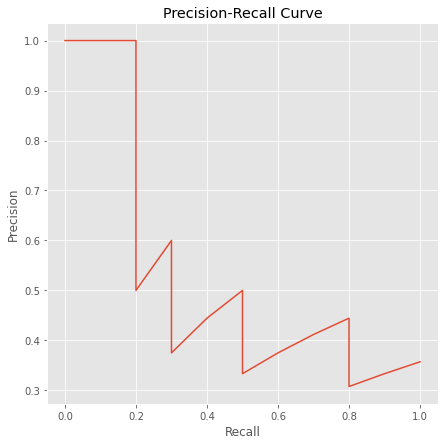

In [35]:
prec_recall_plot(valY, pred_Y1)

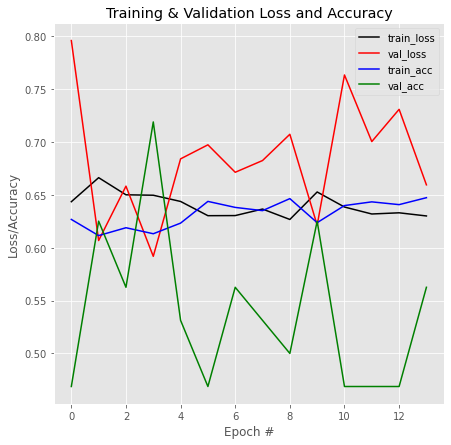

In [36]:
plot_history(hist1)

**Comments: 

Model appears unstable with little learning - overfitting. Need to add more dropout and FC layer(s)

#### 2. Freezing last layer, adding drop-out, and connecting more FC-layers

In [37]:
## using only the last output layer more dropouts and connecting 3 FC layers
## running for 10 epochs to see how if any learning occurs:
my_model2 = build_my_model(vgg_model, layer_num = -1, fc_list = [1024, 512, 256])
my_model2.fit_generator(train_gen, 
                       validation_data = (valX, valY), 
                       epochs = int(num_epochs/4))

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool True
Epoch 1/10
72/72 [==============================] - 59s 817ms/step - loss: 0.7957 - binary_accuracy: 0.5031 - val_loss: 0.6381 - val_binary_accuracy: 0.6875
Epoch 2/10
72/72 [==============================] - 59s 820ms/step - loss: 0.7462 - binary_accuracy: 0.5227 - val_loss: 0.6620 - val_binary_accuracy: 0.6562
Epoch 3/10
72/72 [==============================] - 59s 815ms/step - loss: 0.7271 - binary_accuracy: 0.5284 - val_loss: 0.6844 - val_binary_accuracy: 0.5312
Epoch 4/10
72/72 [==============================] - 59s 819ms/step - loss: 0.7320 - binary_accuracy: 0.5135 - val_loss: 0.7299 - val_binary_accuracy: 0.3750
Epoch 5/10
72/72 [====

In [38]:
weight_path2, callbacks_list2 = checkpoint(my_model2)

In [39]:
hist2 = my_model2.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = num_epochs, 
                           callbacks = callbacks_list2)

Epoch 1/40
72/72 [==============================] - 58s 804ms/step - loss: 0.6869 - binary_accuracy: 0.5751 - val_loss: 0.7536 - val_binary_accuracy: 0.3438

Epoch 00001: val_loss improved from inf to 0.75364, saving model to xray_class_<keras.engine.sequential.Sequential object at 0x7fdca7ebc9d0>.best.hdf5
Epoch 2/40
72/72 [==============================] - 57s 798ms/step - loss: 0.7014 - binary_accuracy: 0.5546 - val_loss: 0.7370 - val_binary_accuracy: 0.3438

Epoch 00002: val_loss improved from 0.75364 to 0.73696, saving model to xray_class_<keras.engine.sequential.Sequential object at 0x7fdca7ebc9d0>.best.hdf5
Epoch 3/40
72/72 [==============================] - 57s 790ms/step - loss: 0.6943 - binary_accuracy: 0.5607 - val_loss: 0.6686 - val_binary_accuracy: 0.5938

Epoch 00003: val_loss improved from 0.73696 to 0.66857, saving model to xray_class_<keras.engine.sequential.Sequential object at 0x7fdca7ebc9d0>.best.hdf5
Epoch 4/40
72/72 [==============================] - 58s 799ms/ste

In [40]:
my_model2.load_weights(weight_path2)
pred_Y2 = my_model2.predict(valX, batch_size = 32, verbose = True)

32/32 [==============================] - 0s 12ms/step


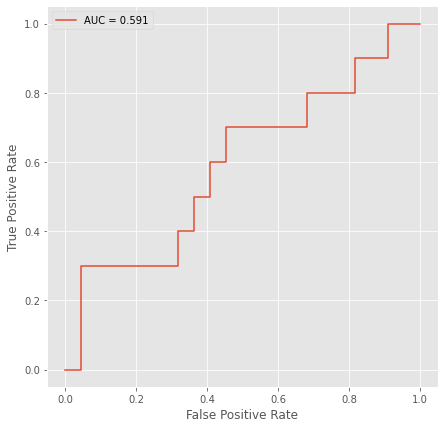

In [41]:
plot_auc(valY, pred_Y2)

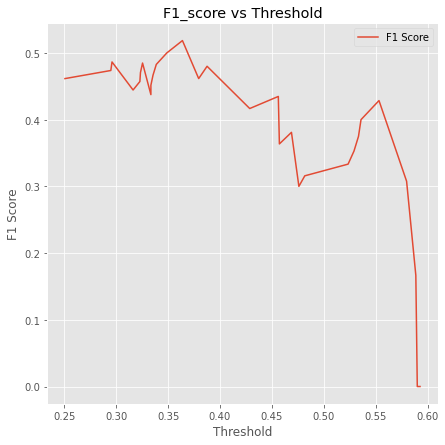

In [42]:
f1_plot(valY, pred_Y2)

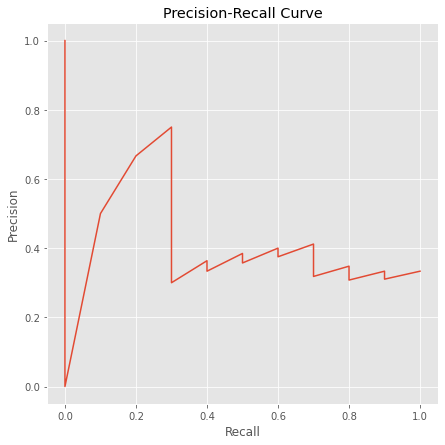

In [43]:
prec_recall_plot(valY, pred_Y2)

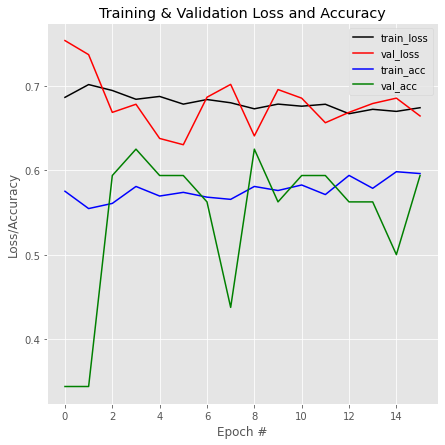

In [44]:
plot_history(hist2)

#### Comments: 

From the history plot, it can be seen that the model appears stable and very promising at 6 epochs.

In [45]:
## using only the last output layer more dropouts and connecting 4 FC layer
## running for 10 epochs to see how if any learning occurs:
my_model3 = build_my_model(vgg_model, layer_num = -1, fc_list = [1024, 512, 256, 128])
my_model3.fit_generator(train_gen, 
                       validation_data = (valX, valY), 
                       epochs = int(num_epochs/4))

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool True
Epoch 1/10
72/72 [==============================] - 56s 783ms/step - loss: 0.8159 - binary_accuracy: 0.5096 - val_loss: 0.6402 - val_binary_accuracy: 0.6875
Epoch 2/10
72/72 [==============================] - 56s 782ms/step - loss: 0.7816 - binary_accuracy: 0.4983 - val_loss: 0.6767 - val_binary_accuracy: 0.6875
Epoch 3/10
72/72 [==============================] - 58s 806ms/step - loss: 0.7527 - binary_accuracy: 0.4904 - val_loss: 0.6743 - val_binary_accuracy: 0.6875
Epoch 4/10
72/72 [==============================] - 57s 794ms/step - loss: 0.7299 - binary_accuracy: 0.5210 - val_loss: 0.6530 - val_binary_accuracy: 0.6875
Epoch 5/10
72/72 [====

In [46]:
weight_path3, callbacks_list3 = checkpoint(my_model3)

In [47]:
hist3 = my_model3.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = num_epochs, 
                           callbacks = callbacks_list3)

Epoch 1/40
72/72 [==============================] - 58s 802ms/step - loss: 0.7067 - binary_accuracy: 0.5179 - val_loss: 0.6847 - val_binary_accuracy: 0.5312

Epoch 00001: val_loss improved from inf to 0.68475, saving model to xray_class_<keras.engine.sequential.Sequential object at 0x7fdca8470d90>.best.hdf5
Epoch 2/40
72/72 [==============================] - 56s 777ms/step - loss: 0.7036 - binary_accuracy: 0.5293 - val_loss: 0.6601 - val_binary_accuracy: 0.7500

Epoch 00002: val_loss improved from 0.68475 to 0.66010, saving model to xray_class_<keras.engine.sequential.Sequential object at 0x7fdca8470d90>.best.hdf5
Epoch 3/40
72/72 [==============================] - 58s 801ms/step - loss: 0.6997 - binary_accuracy: 0.5402 - val_loss: 0.6956 - val_binary_accuracy: 0.5625

Epoch 00003: val_loss did not improve from 0.66010
Epoch 4/40
72/72 [==============================] - 58s 800ms/step - loss: 0.7025 - binary_accuracy: 0.5371 - val_loss: 0.6542 - val_binary_accuracy: 0.6250

Epoch 00004


Epoch 00035: val_loss did not improve from 0.63196
Epoch 36/40
72/72 [==============================] - 57s 791ms/step - loss: 0.6601 - binary_accuracy: 0.6170 - val_loss: 0.6431 - val_binary_accuracy: 0.5938

Epoch 00036: val_loss did not improve from 0.63196
Epoch 37/40
72/72 [==============================] - 57s 796ms/step - loss: 0.6654 - binary_accuracy: 0.6039 - val_loss: 0.6664 - val_binary_accuracy: 0.5000

Epoch 00037: val_loss did not improve from 0.63196
Epoch 38/40
72/72 [==============================] - 57s 787ms/step - loss: 0.6592 - binary_accuracy: 0.6201 - val_loss: 0.6546 - val_binary_accuracy: 0.6250

Epoch 00038: val_loss did not improve from 0.63196
Epoch 39/40
72/72 [==============================] - 58s 806ms/step - loss: 0.6560 - binary_accuracy: 0.6079 - val_loss: 0.6637 - val_binary_accuracy: 0.5625

Epoch 00039: val_loss did not improve from 0.63196
Epoch 40/40
72/72 [==============================] - 57s 794ms/step - loss: 0.6569 - binary_accuracy: 0.6218

In [48]:
my_model3.load_weights(weight_path3)
pred_Y3 = my_model3.predict(valX, batch_size = 32, verbose = True)

32/32 [==============================] - 0s 12ms/step


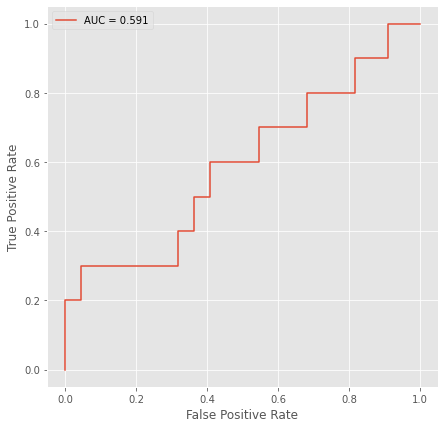

In [49]:
plot_auc(valY, pred_Y3)

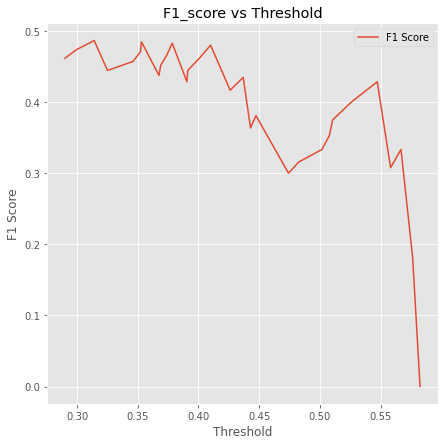

In [50]:
f1_plot(valY, pred_Y3)

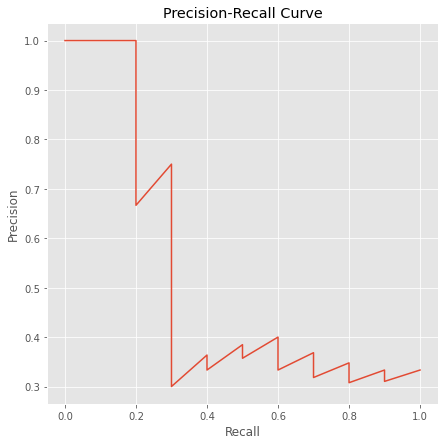

In [51]:
prec_recall_plot(valY, pred_Y3)

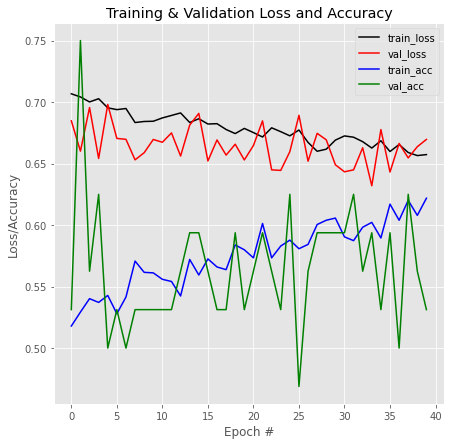

In [52]:
plot_history(hist3)

#### Comments: 

From the history plot, it can be seen that the model appears unstable and but promising with lower validation loss than training loss. Training loss decreasing shows model was learning.

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [71]:
# compute precision, recall and threshold using the "best" model
precision, recall, thresholds = precision_recall_curve(valY, pred_Y2)

# compute the corresponding f1_scores
f1_score = calc_f1(precision,recall)

# compute the best threshold
best_threshold = best_threshold(precision,recall)

Threshold that maximized f1_score is: 0.38
Corresponding Precision is: 0.41
Recall is: 0.70


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


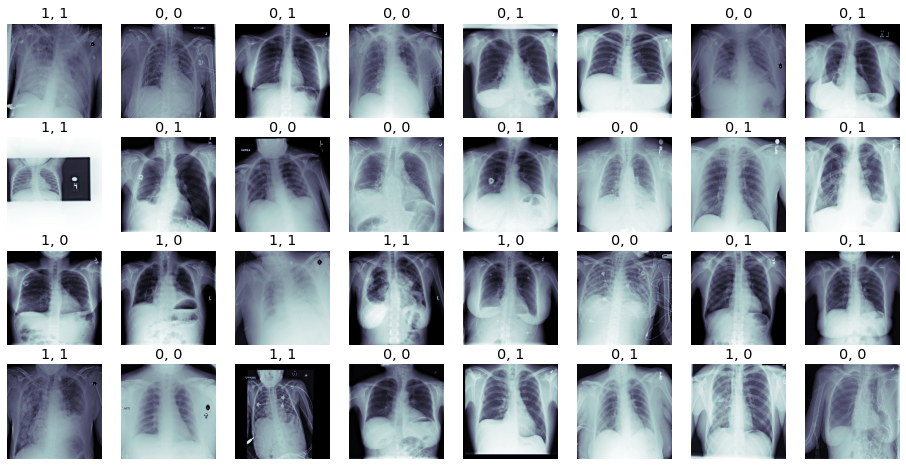

In [78]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

#best_threshold = best_threshold
YOUR_THRESHOLD = best_threshold

fig, m_axs = plt.subplots(4, 8, figsize = (16, 8))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:], valY[0:], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y2[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y2[i] < YOUR_THRESHOLD:
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1


In [55]:
## Just save model architecture to a .json:

model_json = my_model2.to_json()
with open("my_model2.json", "w") as json_file:
    json_file.write(model_json)